<a href="https://colab.research.google.com/github/wenqiglantz/multi_modal_retrieval_backyard_birds/blob/main/multi_modal_retrieval_backyard_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Retrieval with Text Embedding and CLIP Image Embedding for Backyard Birds

A little app I made for my daughter who loves birds. :-)

* Step 1: Download backyard birds text and images
* Step 2: Build text index for vector store and define text query engine
* Step 3: Build image index for vector store using CLIP embeddings, and define functions for image query
* Step 4: Multimodal retrieval of both image and text for sample queries

Models used in this notebook:
* OpenAI CLIP model ViT-B/32 for image embeddings
* BAAI/bge-base-en-v1.5 for text embeddings
* Experimented with zephyr-7b-beta as LLM for text, but result was not ideal, so commented out code related to zephyr-7b-beta and reverted to use gpt-3.5-turbo

In [ ]:
!pip install llama_index==0.8.53.post3 tqdm llama_hub sentence-transformers accelerate bitsandbytes
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install matplotlib scikit-image
!pip install -U qdrant_client

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z0hjy83g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z0hjy83g
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [ ]:
import os, logging, sys

os.environ["OPENAI_API_KEY"] = "sk-#########################"
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

## Download backyard birds text and images

### Download multimodal backyard birds text

In [ ]:
!mkdir data
!mkdir images

# download webpage into html file and store it locally
!curl https://abcbirds.org/blog/backyard-birds/ --output ./data/backyard-birds.html

from pathlib import Path
from llama_index import download_loader
from llama_index import SimpleDirectoryReader

# load the downloaded file as an unstructured document
UnstructuredReader = download_loader('UnstructuredReader')

# load all of the unstructured data files from the ./data/ directory into a list.
dir_reader = SimpleDirectoryReader('./data', file_extractor={
  ".html": UnstructuredReader()
})
documents = dir_reader.load_data()
print(f'Loaded {len(documents)} documents')

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘images’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  160k  100  160k    0     0    99k      0  0:00:01  0:00:01 --:--:--   99k


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loaded 1 documents


### Load the bird images and generate image metadata

In [ ]:
import os

# image_metadata_dict stores images metadata including filename and path
image_metadata_dict = {}

# Get a list of all the image files in the `images` folder.
image_files = os.listdir("images")

# Loop through each image file and add metadata.
for image_file in image_files:
  image_path = os.path.join("images", image_file)
   # Get the image filename.
  image_filename = os.path.basename(image_path)

  # Get the image file path.
  image_file_path = os.path.abspath(image_path)

  # Create a dictionary to store the image metadata.
  image_metadata_dict[image_filename] = {
    "filename": image_filename,
    "img_path": image_file_path,
  }


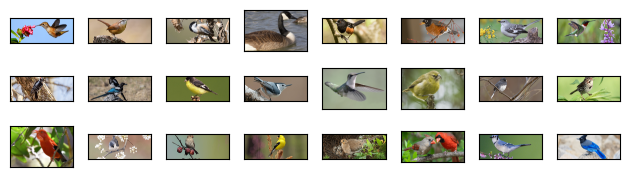

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# a simple and useful way to plot multiple images in a grid
def plot_images(image_metadata_dict):
    images = []
    images_shown = 0
    for image_filename in image_metadata_dict:
        img_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_path):
            # open the image file and convert it to RGB colorspace.
            filename = image_metadata_dict[image_filename]["filename"]
            image = Image.open(img_path).convert("RGB")

            # plot the image in a subplot of an 8x8 grid, also disables the tick labels on the axes to make the plot cleaner.
            plt.subplot(8, 8, len(images) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()

plot_images(image_metadata_dict)

## Build Vector Store using bge-base-en-v1.5 embeddings for backyard birds text

In [ ]:
# import torch
# from transformers import BitsAndBytesConfig
# from llama_index.prompts import PromptTemplate
# from llama_index.llms import HuggingFaceLLM

# # load a model in 4bit using NF4 quantization with double quantization with the compute dtype bfloat16 for faster training
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_use_double_quant=True,
# )

# def messages_to_prompt(messages):
#   prompt = ""
#   for message in messages:
#     if message.role == 'system':
#       prompt += f"<|system|>\n{message.content}</s>\n"
#     elif message.role == 'user':
#       prompt += f"<|user|>\n{message.content}</s>\n"
#     elif message.role == 'assistant':
#       prompt += f"<|assistant|>\n{message.content}</s>\n"

#   # ensure we start with a system prompt, insert blank if needed
#   if not prompt.startswith("<|system|>\n"):
#     prompt = "<|system|>\n</s>\n" + prompt

#   # add final assistant prompt
#   prompt = prompt + "<|assistant|>\n"

#   return prompt


# llm_zephyr = HuggingFaceLLM(
#     model_name="HuggingFaceH4/zephyr-7b-beta",
#     tokenizer_name="HuggingFaceH4/zephyr-7b-beta",
#     query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
#     context_window=3900,
#     max_new_tokens=256,
#     model_kwargs={"quantization_config": quantization_config},
#     generate_kwargs={"temperature":0.1, "top_k": 50},
#     messages_to_prompt=messages_to_prompt,
#     device_map="auto",
# )

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
import qdrant_client
from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.llms import OpenAI

# create QdrantClient with the location set to ":memory:", which means the vector db will be stored in memory
text_client = qdrant_client.QdrantClient(location=":memory:")

# load text documents from the data directory
text_documents = SimpleDirectoryReader("./data").load_data()

# define llm and embedding model in ServiceContext
service_context = ServiceContext.from_defaults(
    # llm=llm_zephyr,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-base-en-v1.5"
)

# create QdrantVectorStore using QdrantClient and the collection name "birds_text"
text_vector_store = QdrantVectorStore(
    client=text_client, collection_name="birds_text"
)

# create StorageContext object using the QdrantVectorStore
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

# create VectorStoreIndex using the text documents and StorageContext
birds_text_index = VectorStoreIndex.from_documents(
    text_documents,
    storage_context=storage_context,
    service_context=service_context
)

# define text query engine
text_query_engine = birds_text_index.as_query_engine()

## Build image index for vector store using CLIP embeddings

### Load and initialize CLIP model

In [ ]:
import torch
import clip
import numpy as np

# load the CLIP model with the name ViT-B/32
model, preprocess = clip.load("ViT-B/32")

# the resolution of the input images expected by the model
input_resolution = model.visual.input_resolution

# the maximum length of the input text
context_length = model.context_length

# the size of the vocabulary used by the model
vocab_size = model.vocab_size

# print the information about the model to the console
print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


### Generate Clip embedding for each bird image

In [ ]:
# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():

    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_filename in image_metadata_dict:
        img_file_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 1
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )

            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_filename] = image_features

cuda


### Build CLIP image embedding index under collection `birds_img`

In [ ]:
from llama_index.schema import ImageDocument

# create a list of ImageDocument objects, one for each image in the dataset
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]
        print(filepath)

        # create an ImageDocument for each image
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

# create QdrantVectorStore, with collection name "birds_img"
image_vector_store = QdrantVectorStore(
    client=text_client, collection_name="birds_img"
)

# define storage context
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

# define image index
image_index = VectorStoreIndex.from_documents(
    img_documents,
    storage_context=storage_context
)

/content/images/Rufous-Hummingbird.-Photo-by-Steve-Byland-Shutterstock..png
/content/images/Carolina-Wren.-Photo-by-Glenn-Price-Shutterstock..png
/content/images/Black-capped-Chickadee.-Photo-by-Larry-Master..png
/content/images/Canada-Goose-by-JERutter_banner-image-768x498.png
/content/images/Spotted-Towhee.-Photo-by-Denise-LaPerriere-Shutterstock..png
/content/images/American-Robin.-Photo-by-Larry-Master..png
/content/images/Northern-Mockingbird.-Photo-by-Raul-Baena-Shutterstock..png
/content/images/Ruby-throated-Hummingbird.-Photo-by-Fiona-M.-Donnelly-Shutterstock..png
/content/images/Downy-Woodpecker.-Photo-by-mshirani-Shutterstock..png
/content/images/Black-billed-Magpie.-Photo-by-Dennis-W-Donohue-Shutterstock..png
/content/images/Lesser-Goldfinch.-Photo-by-Steve-Byland-Shutterstock..png
/content/images/White-breasted-Nuthatch.-Photo-by-Larry-Master..png
/content/images/Ruby-throated-Hummingbird-female.-Photo-by-David-O.-Hill_1600x900-768x498.png
/content/images/Kiwikiu_Zach-Pezzi

## Define functions for image query

In [ ]:
from llama_index.vector_stores import VectorStoreQuery

# take a text query as input and return the most similar image from the vector store
def retrieve_results_from_image_index(query):

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # only return 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results

In [ ]:
# take a list of image retrieval results and create a new figure with a size of 16 by 5 inches
def plot_image_retrieve_results(image_retrieval_results):
    plt.figure(figsize=(16, 5))

    img_cnt = 0
    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The subplot is 2 by 3, and the image is displayed in the img_cnt + 1th subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.
    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [ ]:
# define image_query function
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)

## Multimodal retrieval of both image and text for sample queries

Blue Jays can be recognized by their distinctive blue coloration, crest on their head, and black markings around their neck and on their face. They are medium-sized birds and have a robust build. Their call is also quite recognizable, often described as a loud and harsh "jay-jay" or "jay-jay-jay." Blue Jays are commonly found in forests, woodlands, and suburban areas throughout North America.


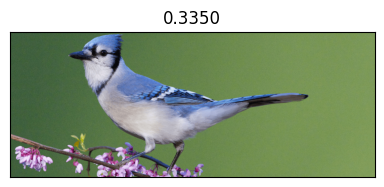

In [ ]:
query = "How do we recognize Blue Jays?"
# generate Image retrieval results
image_query(query)

# generate Text retrieval results
text_retrieval_results = text_query_engine.query(query)
print(str(text_retrieval_results))

Steller Jays eat a variety of foods, including insects, seeds, nuts, berries, and occasionally small vertebrates.


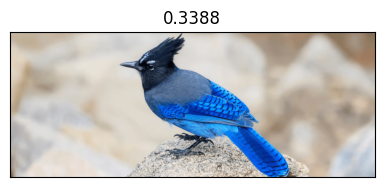

In [ ]:
query = "What do Steller Jays eat?"
# generate Image retrieval results
image_query(query)

# generate Text retrieval results
text_retrieval_results = text_query_engine.query(query)
print(str(text_retrieval_results))

The yellow hue of the American Goldfinch comes from its bright yellow underparts.


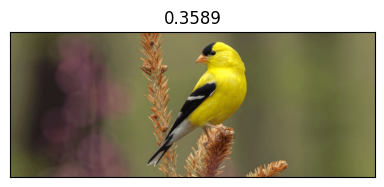

In [ ]:
query = "Where does American Goldfinch's yellow hue come from?"
# generate Image retrieval results
image_query(query)

# generate Text retrieval results
text_retrieval_results = text_query_engine.query(query)
print(str(text_retrieval_results))

The type of hummingbird that breeds in the eastern U.S. is the Ruby-throated Hummingbird.


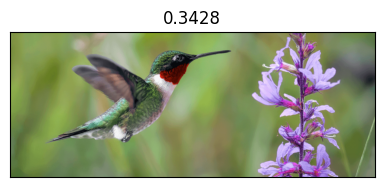

In [ ]:
query = "what type of Hummingbird breeds in the eastern U.S.?"
# generate Image retrieval results
image_query(query)

# generate Text retrieval results
text_retrieval_results = text_query_engine.query(query)
print(str(text_retrieval_results))

Northern Cardinals are easily recognizable birds with their distinctive features. The males have a head crest, black mask, chunky orange bill, and brilliant red plumage. Females, on the other hand, are a soft grayish tan but share the same field marks as males. Both males and females sing, and their songs, such as "cheer, cheer, cheer" and "birdie, birdie, birdie," can sometimes sound like car alarms. The Northern Cardinal is the state bird of seven states and was originally found in the southern U.S. However, it has gradually expanded its range into the Northeast since at least the mid-1800s. It can also be found in the Southwest, from West Texas through southern Arizona.


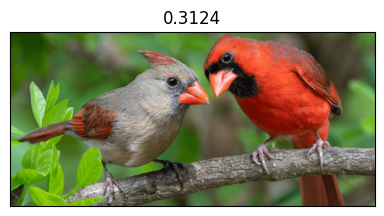

In [ ]:
query = "Tell me about Northern Cardinals."
# generate Image retrieval results
image_query(query)

# generate Text retrieval results
text_retrieval_results = text_query_engine.query(query)
print(str(text_retrieval_results))